# Parallel Sampling Trajectory Visualization

Here we visualize the parallel sampling trajectory, which shows convergence speed. 

In [1]:
import json
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

/home/ywu380/miniconda3/envs/cdl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cdl_trajectory_buffer = torch.load('../test_scripts/results_ddpm_scheduler/trajectory_buffer_parallel_sampling_cdl_1DGauss.pt').cpu()
itd_trajectory_buffer = torch.load('../test_scripts/results_ddpm_scheduler/trajectory_buffer_parallel_sampling_itd_1DGauss.pt').cpu()
ddpm_trajectory_buffer = torch.load('../test_scripts/results/trajectory_buffer_parallel_sampling_ddpm_1DGauss.pt').cpu()

print(f'check shape: {cdl_trajectory_buffer.shape}')

check shape: torch.Size([32, 1001, 1])


## Check Parallel Samplling Speed and MMD

#### CDL

In [3]:
parallel_sampled_1DGauss = torch.load('../test_scripts/results_ddpm_scheduler/parallel_sampling_cdl_1DGauss.pt')
cdl_1DGauss = parallel_sampled_1DGauss.cpu().numpy()
print(cdl_1DGauss[0])

with open('../test_scripts/results/stats_cdl_1DGauss.json', 'r') as file: 
    cdl_stats = json.load(file)

print(f'stats = {cdl_stats}')

[20.464348]
stats = {'pass_count': 24, 'flops_count': 20889, 'time': 6784.37158203125, 'MMD thredshold reached?': False}


In [4]:
parallel_sampled_1DGauss = torch.load('../test_scripts/results_ddpm_scheduler/parallel_sampling_itd_1DGauss.pt')
itd_1DGauss = parallel_sampled_1DGauss.cpu().numpy()
print(itd_1DGauss[0])

with open('../test_scripts/results_ddpm_scheduler/stats_itd_1DGauss.json', 'r') as file: 
    itd_stats = json.load(file)

print(f'stats = {itd_stats}')

[20.369999]
stats = {'pass_count': 38, 'flops_count': 24446, 'time': 3017.3388671875}


In [5]:
parallel_sampled_1DGauss = torch.load('../test_scripts/results/parallel_sampling_ddpm_1DGauss.pt')
ddpm_1DGauss = parallel_sampled_1DGauss[0].cpu().numpy()
print(ddpm_1DGauss)

with open('../test_scripts/results/stats_ddpm_1DGauss.json', 'r') as file: 
    ddpm_stats = json.load(file)

print(f'stats = {ddpm_stats}')

[48.85118]
stats = {'pass_count': 26, 'flops_count': 17807, 'time': 3402.262451171875}


## Preparation

In [6]:
max_picard_iter = max(len(cdl_trajectory_buffer), len(itd_trajectory_buffer), len(ddpm_trajectory_buffer))
print(max_picard_iter)

list_trajectories = []

for buffer in (cdl_trajectory_buffer, itd_trajectory_buffer, ddpm_trajectory_buffer):
    if len(buffer) < max_picard_iter:
        # append tensor=[None] 
        slice_to_append = torch.tensor([torch.inf])
        print(f'before append, buffer shape = {buffer.shape}')
        slice_to_append = slice_to_append.expand(max_picard_iter-len(buffer), *buffer[0].shape)
        print(f'slice_to_append = {slice_to_append.shape}')
        buffer = torch.cat((buffer, slice_to_append), dim=0)
        print(f'after append, buffer shape = {buffer.shape}')
    list_trajectories.append(buffer)

for traje in list_trajectories:
    print(len(traje))

39
before append, buffer shape = torch.Size([32, 1001, 1])
slice_to_append = torch.Size([7, 1001, 1])
after append, buffer shape = torch.Size([39, 1001, 1])
before append, buffer shape = torch.Size([27, 1001, 1])
slice_to_append = torch.Size([12, 1001, 1])
after append, buffer shape = torch.Size([39, 1001, 1])
39
39
39


## Sanity Check

### Plot the initial trajectory at picard iteration $K=0$

In [7]:
cdl_trajectory_0 = cdl_trajectory_buffer[0]
print(cdl_trajectory_0.shape)

torch.Size([1001, 1])


In [8]:
x_axis = torch.arange(len(cdl_trajectory_0))
y_axis = cdl_trajectory_0.squeeze().numpy()
print(y_axis.shape)

(1001,)


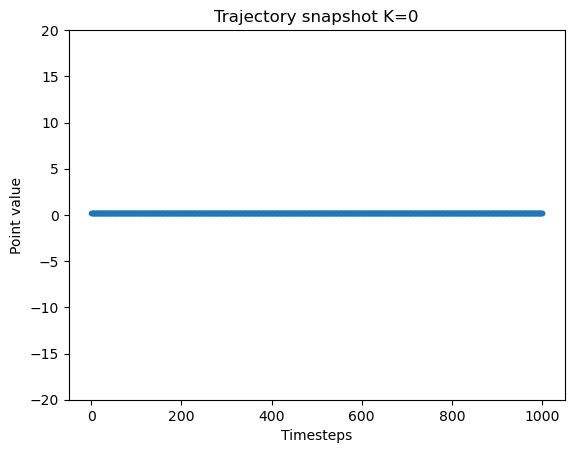

In [9]:
i = 0
fig, ax = plt.subplots(1, 1)

ax.scatter(x_axis, cdl_trajectory_buffer[i].squeeze().numpy(), marker='.')
ax.set_xlabel('Timesteps')  # Correct method to set the x-axis label
ax.set_ylabel('Point value')  # Correct method to set the y-axis label
ax.set_title('Trajectory snapshot K=0')  # Correct method to set the title
ax.grid(False)
ax.set_ylim(-20, 20)  # Use set_ylim to adjust y-axis limits

plt.show()  # Correct function to display the plot

fig.savefig(f'./figs/1d_cdl_t{i}.pdf')  # Saving the figure

### Plot all trajectories K=0,...,T

In [10]:
YLIM = 30

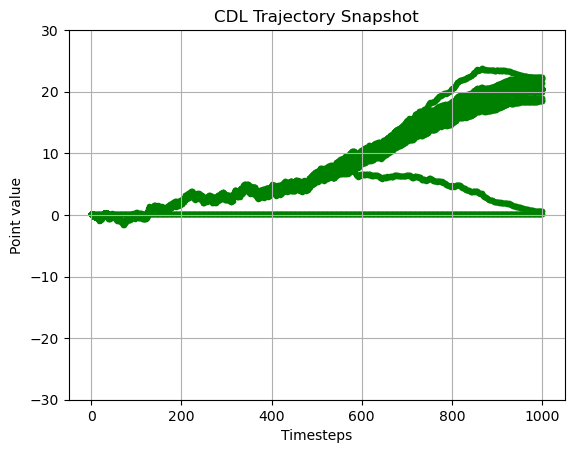

In [11]:
for t_i in cdl_trajectory_buffer:
    x_axis = torch.arange(len(t_i))
    y_axis = t_i.squeeze().numpy()
    plt.scatter(x_axis, y_axis, color='g', marker='.')
    plt.xlabel('Timesteps')
    plt.ylabel('Point value')
    plt.title('CDL Trajectory Snapshot')
    plt.grid(True)
    plt.ylim(-YLIM, YLIM)
    plt.plot() # plot all t_i plot in one
    # plt.shoow() # plot t_i plot separately

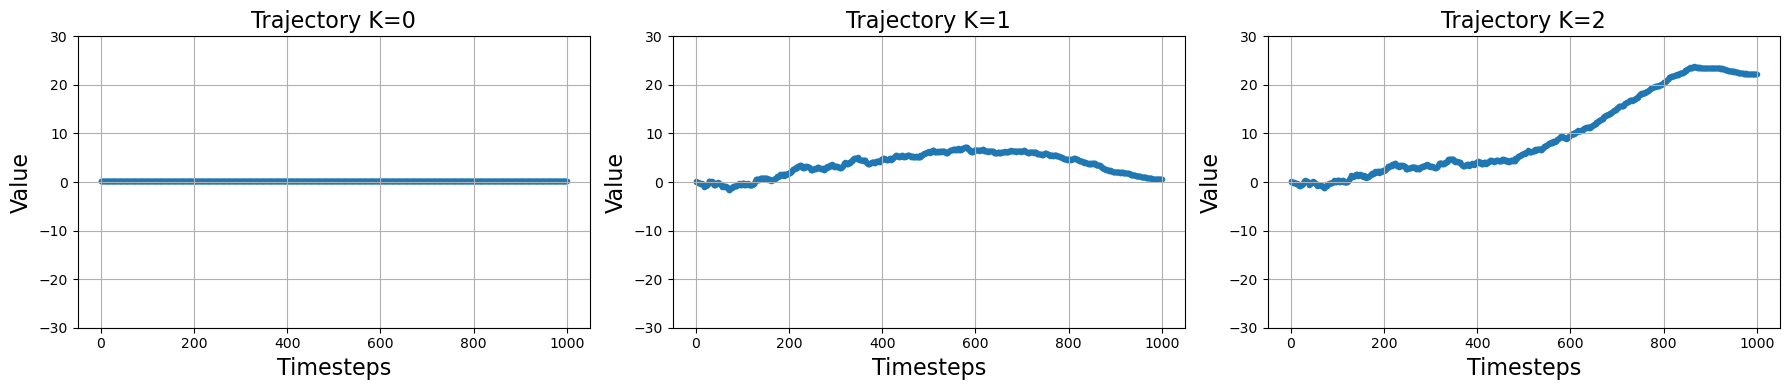

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))  # 1 row, 3 columns, wider figure

for i in range(3):  # Loop through the first three elements
    t_i = cdl_trajectory_buffer[i]
    x_axis = torch.arange(len(t_i))
    y_axis = t_i.squeeze().numpy()

    # Plot on the ith subplot
    axs[i].scatter(x_axis, y_axis, marker='.')
    axs[i].set_xlabel('Timesteps', fontsize=16)
    axs[i].set_ylabel('Value', fontsize=16)
    axs[i].set_title(f'Trajectory K={i}', fontsize=16)
    axs[i].grid(True)
    axs[i].set_ylim(-YLIM, YLIM)

# Adjust the layout so that labels do not overlap
plt.tight_layout()

# Save the figure before showing it
plt.savefig('./trajectories.pdf')
plt.show()

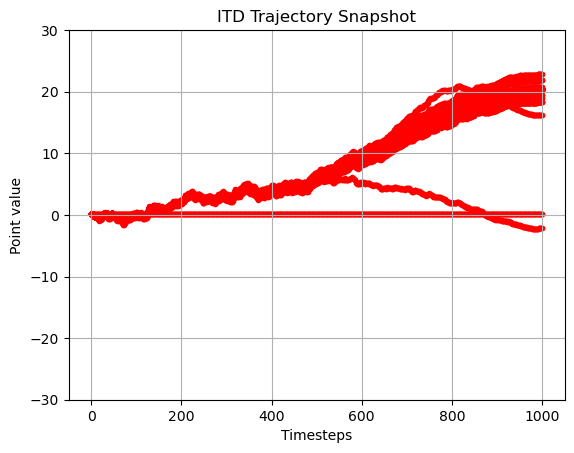

In [13]:
for t_i in itd_trajectory_buffer:
    x_axis = torch.arange(len(t_i))
    y_axis = t_i.squeeze().numpy()
    plt.scatter(x_axis, y_axis, color='r', marker='.')
    plt.xlabel('Timesteps')
    plt.ylabel('Point value')
    plt.title('ITD Trajectory Snapshot')
    plt.grid(True)
    plt.ylim(-YLIM, YLIM)
    plt.plot() # plot all t_i plot in one
    # plt.shoow() # plot t_i plot separately

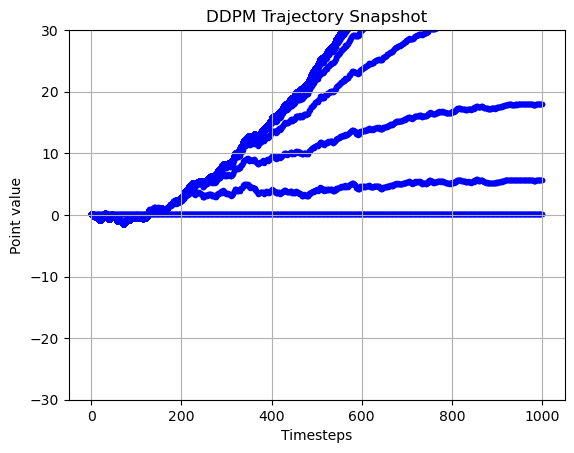

In [14]:
for t_i in ddpm_trajectory_buffer:
    x_axis = torch.arange(len(t_i))
    y_axis = t_i.squeeze().numpy()
    plt.scatter(x_axis, y_axis, color='b', marker='.')
    plt.xlabel('Timesteps')
    plt.ylabel('Point value')
    plt.title('DDPM Trajectory Snapshot')
    plt.grid(True)
    plt.ylim(-YLIM, YLIM)
    plt.plot() # plot all t_i plot in one
    # plt.shoow() # plot t_i plot separately

## Animations

MovieWriter imagemagick unavailable; using Pillow instead.


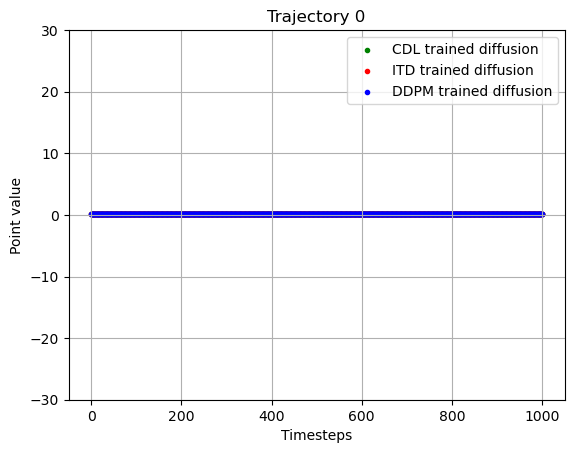

In [15]:
def update(frame):
    y_min = -YLIM
    y_max = YLIM
    plt.cla()

    cdl_x_axis = torch.arange(len(list_trajectories[0][frame]))
    cdl_y_axis = list_trajectories[0][frame].squeeze().numpy()
    plt.scatter(cdl_x_axis, cdl_y_axis, color='g', marker='.', label='CDL trained diffusion')

    itd_x_axis = torch.arange(len(list_trajectories[1][frame]))
    itd_y_axis = list_trajectories[1][frame].squeeze().numpy()
    plt.scatter(itd_x_axis, itd_y_axis, color='red', marker='.', label='ITD trained diffusion')

    ddpm_x_axis = torch.arange(len(list_trajectories[2][frame]))
    ddpm_y_axis = list_trajectories[2][frame].squeeze().numpy()
    plt.scatter(ddpm_x_axis, ddpm_y_axis, color='b', marker='.', label='DDPM trained diffusion')

    plt.xlabel('Timesteps')
    plt.ylabel('Point value')
    plt.title('Trajectory {}'.format(frame))
    plt.legend()

    plt.grid(True)
    plt.ylim(y_min, y_max)

fig = plt.figure()
ani = animation.FuncAnimation(fig, update, frames=len(list_trajectories[0]), interval=500)
ani.save('./gif_para_trajectory/trajectory_animation.gif', writer='imagemagick')